In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

def sigmoid(z): 
    return 1 / (1 + np.exp(-z))

def softmax(zs):
    return np.exp(zs) / sum(np.exp(zs))

=================================================================================================================
# Lecture Notes: Logistic Regression


##### D.Vidotto, Data Mining: JBI030 2019/2020


=================================================================================================================

With this notebook we will explore the *logistic regression* (LR) algorithm. In particular, we will go through the theoretical concepts explored during the dedicated lecture by means of Python code and examples. It is assumed that students have followed the related lecture, and have understood the following concepts: 

* Bernoulli distribution 
* linear separator/decision boundary 
* maximum likelihood estimation 
* interpretation of the LR coefficients 
* regularization in LR 
* logistic regression in multi-class case (a.k.a. multinomial logistic regression)

In this notebook, we are going to delve into the following topics: 

1. Logistic Regression: main ingredients
1. Estimation (Review)
1. Logistic Regression in scikit-learn
  * Model estimates 
  * Model predictions and decision boundaries
  * Model interpretation 
1. Model regularization
  * ridge
  * lasso 
1. Multi-class case 
1. Other Remarks
1. Example on the Heart dataset 

## 1. Logistic Regression: Main Ingredients
In what follows, we will assume we have two classes, Class 0 and Class 1, and we take Class 1 to be the *positive class*; we encode the target (=output) variable $Y$ as follows: 

$$ Y_i = 
\left\{
\begin{array}{rl}
0 & \ for\ Class\ 0 \\
1 & \ for\ Class\ 1
\end{array}
\right.
$$

for each $i=1,...,n$, where $n$ is the sample size in this case. Thus, a classifier seeks to first estimate the probability 

$$ p_i = \Pr(Y_i = 1|\mathbf{x}_i), $$ 

and subsequently assigning each instance to Class 0 or Class 1 given such probabilities. In the formula above, $\mathbf{x}_i$ is the $p$-dimensional vector of features observed for the $i$-th instance; that is, $\mathbf{x}_i$ is the $i$-th row of the feature matrix $\mathbf{X} = (X_1,X_2,...,X_p)$. To perform class assignments, $i$ can be assigned to Class 1 if, for example, $\Pr(Y_i = 1|\mathbf{X}_i) >= 0.5$ (where 0.5 is a *threshold*); or to Class 0 otherwise. (As we have seen in past lectures, 0.5 is a reasonable, but not always optimal, threshold, and it can be modified if necessary).   

Now consider the following dataset (two classes, two features): 

<img src="./img/logistic_regression/lin_sep_data_a.png" width="400" height="50"/>

Roughly, it seems like most of the data points in the "top-left" corner until the middle diagonal (from bottom-left to top-right) of the graph belong to Class 0; and most of data points in the "bottom-right" slice of the 2D-space belong to Class 1. In this case, we can then try to learn a *linear function* that separates the two classes (allowing for some noise):  

<img src="./img/logistic_regression/lin_sep_data_b.png" width="400" height="50"/>

To find such linear boundaries, statistics provides us with the *logistic regression* (LR) model, which is an instance of [Generalized Linear Models](https://en.wikipedia.org/wiki/Generalized_linear_model). The main ingredients used by LR models are the following ones: 

1. a *decision function*, which is a *hyperplane* in this case (linear decision function); this function has the form of a *linear combination* of the features, that is 

<br>
$$ f(\mathbf{x}) = w_0 + w_1x_{1} + w_2x_{2} + \cdots + w_px_{p} = w_0 + \mathbf{w}^T\mathbf{x} $$ <br> where: 
<br> 

 * $w_0$ is the *intercept* (a.k.a. *bias* of the model; not to be confused with the bias of the predictions discussed in past lectures). It tells us what's the *expected value* of the decision function is, when all the features are equal to 0  
 * $w_1,...,w_p$ are the *slopes* (a.k.a coefficients or weights) of the model; each slope tells us what is the expected change in the decision function when increasing the corresponding feature by one unit, *while keeping all other features constant* 
 * $\mathbf{w} = [w_1,...,w_p]$ is the vector containing all the model parameters 
 * $\mathbf{x} = [x_{1},...,x_{p}]$ are the points in the feature space <br> Once the value of the weights and bias is known, we can calculate the value $f(\mathbf{x}_i)$ for each training/test unit. Statisticians refer to the decision function of Logistic Regression as *linear predictor* 
 
2. the [*sigmoid function*](https://en.wikipedia.org/wiki/Sigmoid_function) (also called logistic function) is denoted with $\sigma$, and (typically) used to map the values of the decision function $f(\mathbf{x}_i) \in \mathbb{R}$, to values in [0,1]. The resulting value, $\sigma(f(\mathbf{x}))$, can be interpreted as the *probability to belong to the positive class*. For a value $z \in \mathbb{R}$, the sigmoid function  is defined as follows (you can see its shape in the next figure below):

$$\sigma(\cdot): \mathbb{R} \rightarrow [0,1]$$
$$\sigma(z) = \frac{1}{1+e^{-z}}$$ 

3. last, LR uses a *back-ward transformation* of the sigmoid function to calculate the linear scores starting from the prediction probabilities. This transformation is the *logit function*, defined as: <br> $$logit\left(\sigma(w_0+\mathbf{w}^T\mathbf{x}_i)\right) = log\left(\frac{\sigma(w_0+\mathbf{w}^T\mathbf{x}_i)}{1-\sigma(w_0+\mathbf{w}^T\mathbf{x}_i)}\right) = w_0+\mathbf{w}^T\mathbf{x}_i$$ <br> Under this perspective, we can give another interpretation to the decision function: it is the [log-odds ratio](https://www.statisticshowto.datasciencecentral.com/log-odds/) of the probability to belong to the positive class over the negative one. Statisticians refer to the logit as the *link function* of the Generalized Linear Logistic Regression Model

Therefore, for unit $i$, once we know the values of $w_0$ and $\mathbf{w}$ we can estimate the probability to belong to the positive class as $p_i = \Pr(Y_i = 1|\mathbf{X}_i) = \sigma(w_0+\mathbf{w}^T\mathbf{x}_i)$, and the probability to belong to the negative class as $1-p_i = \Pr(Y_i = 0|\mathbf{X}_i) = 1-\sigma(w_0+\mathbf{w}^T\mathbf{x}_i)$. Graphically, the sigmoid function looks like as follows: 

<img src="./img/logistic_regression/sigmoid.png" width="600" height="50"/>

This showhs that when $f(\mathbf{x}_i)$ is very large or very small, the LR model is more certain of classifying unit $i$ it to the positive/negative class (the extremes of the sigmoid function are close to 0 or 1). As the linear prediction gets close to 0, however, LR becomes more uncertain about the class assignment, and at $f(\mathbf{x}_i)=0$ we have $\sigma(0)=0.5$; thus, the LR model will perform the following prediction for unit $i$: 

$$ \hat{Y}_i = 
\left\{
\begin{array}{rl}
0 & \ if\ \sigma(f(\mathbf{x}_i)) < 0.5 \ or,\ equivalently,\ if\ f(\mathbf{x}_i) < 0 \\
1 & \ if\ \sigma(f(\mathbf{x}_i)) \geq 0.5 \ or,\ equivalently,\ if\ f(\mathbf{x}_i) \geq 0 \\
\end{array}
\right.
$$

(as noted above and in previous lectures, the threshold of 0.5-and consequently the value of 0 for the decision function- can be modified according to the problem we want to solve). Therefore the **linear decision boundary** (linear separator) is defined by all those points in $\mathbf{x}$ such that $f(\mathbf{x}) = 0$. A graphical example of the linear decision boundary is given in the scatterplot above. Points for which $f(\mathbf{x}_i) = w_0+\mathbf{w}^T\mathbf{x}_i \geq 0$ will be classified to the positive class; and all the other points to the negative class. In the plot below, you can see another example of decision boundary for a problem with 1 feature.    

<img src="./img/logistic_regression/1d_log_reg.png" width="600" height="50"/>

**Model form**. Given the three elements of the LR model specified above, we are now ready to see its mathematical formulation, to model the classes of $Y$. The logistic regression model for a single observation $i$ takes the form of a [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution), with $n=1$ trial (equivalent to a Bernoulli distribution). Therefore, for $y_i \in \{0,1\}$: 

$$ \Pr(y_i|\mathbf{x}_i;w_0,\mathbf{w}) = p_i^{y_i}(1-p_i)^{1-y_i} = \sigma(w_0+\mathbf{w}^T\mathbf{x}_i)^{y_i}[1- \sigma(w_0+\mathbf{w}^T\mathbf{x}_i)]^{1-y_i}   $$

which is equal to $\sigma(w_0+\mathbf{w}^T\mathbf{x}_i)$ when $y_i=1$ and to $1- \sigma(w_0+\mathbf{w}^T\mathbf{x}_i)$ when $y_i=0$.

Because $1-\sigma(z)=\sigma(-z)$,  by denoting the negative class with $y=-1$ (instead of 0) we can obtain an equivalent and more compact formulation:

$$ \Pr(y_i|\mathbf{x}_i;w_0,\mathbf{w}) = \sigma\left(y_i(w_0+\mathbf{w}^T\mathbf{x}_i)\right)$$

In this case, the probability is equal to $\sigma(w_0+\mathbf{w}^T\mathbf{x}_i)$ when $y_i=1$ and to $\sigma(-w_0-\mathbf{w}^T\mathbf{x}_i)$ when $y_i=-1$ (check these results by yourself!). From now on, without loss of generality we will use this second formulation (and therefore will use $Y \in \{-1,1\}$), as this is the representation used internally by scikit-learn (*Note*: internally means that scikit-learn performs the transformation of the labels automatically within its algorithm; the labels given as input can be still represented as 0's and 1's, or other values, from the point of view of the users). Nevertheless, with the first representation we can obtain the same results as the one we are going to see.  

Next, when we have a training set with $n$ *independent* examples, we can model the probability of $y_1,...,y_n$ with: 

$$ \Pr(y_1,...,y_n|\mathbf{X};w_0, \mathbf{w}) = \prod_{i=1}^{n}\Pr(y_i|\mathbf{x}_i;w_0,\mathbf{w}) = \prod_{i=1}^{n}\sigma\left(y_i(w_0+\mathbf{w}^T\mathbf{x}_i)\right) $$

which follows from basic probability theory results. 

## 2. Model Estimation
Training a LR model boils down to learn the parameter vector $\mathbf{w}$: once we know it, we can easily plug its estimate to the formulas seen in the previous section, as all the other components of the model are observed. 

**The likelihood function**. The *likelihood function* $\mathcal{L}(w_0,\mathbf{w})$ takes the same form of $\Pr(y_1,...,y_n|\mathbf{X}; w_0,\mathbf{w})$, but it is expressed as a function of the parameter $w_0,\mathbf{w}$ instead of the r.v. $Y_1,...,Y_n$: 

$$ \mathcal{L}(w_0,\mathbf{w}) = \prod_{i=1}^{n}\sigma\left(y_i(w_0+\mathbf{w}^T\mathbf{x}_i)\right)$$

Often, it is easier to work with the *logarithm* of such function, because -among other reasons- it involves summation instead of a product. The log-likelihood $\mathcal{ll}(w_0,\mathbf{w})$ of the LR model is then defined as: 

$$ \mathcal{ll}(w_0,\mathbf{w}) = log\left(\prod_{i=1}^{n}\sigma(y_i(w_0+\mathbf{w}^T\mathbf{x}_i))\right) = -\sum_{i=1}^{n}log\left(1+e^{-y_i(w_0+\mathbf{w}^T\mathbf{x}_i)}\right)  $$
 
(As an exercise, try to show that this result is true.) The following graphs show the log-likelihood function calculated on a simulated dataset; on the left, you can see the log-likelihood as a function of one parameter (called $w$ in the plot); on the right, you can see the contour of the log-likelihood as a function of two coefficients, ($w_1$ and $w_2$). 

<br>

<img src="./img/logistic_regression/likelihood_functions.png" width="800" height="50"/>


The plots also indicate the points in which the log-likelihood is *maximized*: that is, it reaches its maximum value. Another reason why the logarithm of the likelihood is used is that it is a *monotonic transformation*; therefore, $\mathcal{L}(w_0,\mathbf{w})$ and $\mathcal{ll}(w_0,\mathbf{w})$ share the same maximum point.

The values of the arguments, $w_0$ and $\mathbf{w}$, where the (log-)likelihood is maximized can be considered the ones that most likely have generated the data (accounting for sampling uncertainty). **Maximum likelihood estimation** refers to finding such optimum parameter $w_0^{opt},\mathbf{w}^{opt}$, by maximizing the (log)-likelihood function; $w_0^{opt},\mathbf{w}^{opt}$ is then called **maximum likelihood estimate** (MLE). Let's now denote with $\tilde{\mathbf{w}} = [w_0, \mathbf{w}]$ the vector containing the intercept and all the other model coefficients; and with $\tilde{\mathbf{x}}_i = [1, \mathbf{x}_i]$ the vector which contains a 1 and the vector of observations $\mathbf{x}_i$.  Because most optimizers work by minimizing the objective function (a.k.a. loss or cost function) rather than maximizing it, MLE's can be equally found by minimizing the *negative log-likelihood*:  

$$ \mathcal{nll}(\tilde{\mathbf{w}}) = \sum_{i=1}^{n}log\left(1+e^{-y_i\tilde{\mathbf{w}}^T\tilde{\mathbf{x}}_i}\right)  $$

and the optimization problem is: 

$$w_0^{opt},\mathbf{w}^{opt} = \tilde{\mathbf{w}}^{opt}=\min_{\tilde{\mathbf{w}}} \mathcal{nll}(\tilde{\mathbf{w}}) $$

The negative log-likelihood of the logistic regression model is called *log loss* in the Machine Learning community. 

**Finding the MLE**. Let's now denote with $L$ the loss function: 

$$L(\tilde{\mathbf{w}}) = \frac{1}{n}\mathcal{nll}(\tilde{\mathbf{w}}) = \frac{1}{n}\sum_{i=1}^{n}log\left(1+e^{-y_i\tilde{\mathbf{w}}^T\tilde{\mathbf{x}}_i}\right);$$

the gradient of $L$ w.r.t. $\tilde{\mathbf{w}}$ is: 

$$ \nabla L(\tilde{\mathbf{w}}) = 
-\frac{1}{n}\sum_{i=1}^{n} \frac{y_i\tilde{\mathbf{x}_i}}{1 + e^{y_i\tilde{\mathbf{w}}^T\tilde{\mathbf{x}_i}}}$$

Once again, check this result by yourself (note that $\nabla L(\tilde{\mathbf{w}})$ is a vector!).

Unfortunately, by equating such derivative to 0, we cannot find a closed form solution. However, it is possible to use algorithms such as *gradient descent*, *stochastic gradient descent*, or *coordinate descent* to optimize the function; in case of gradient descent, the updating equation -to be iterated until convergence- becomes: 

$$\tilde{\mathbf{w}}_{new} \leftarrow \tilde{\mathbf{w}}_{old} - \eta   \nabla L(\tilde{\mathbf{w}}_{old}) $$

where $\eta$ is the *learning rate*. Other estimation methods include the *Newton-Rhapson method* and *Iteratively Reweighted least squares* (not covered here). 

**Note**: while scikit-learn uses modified versions of Gradient Descent or Newton method (or alternative to those) in the function [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (check the `solver` hyperparameter), it also provides a function from the `sklearn.linear_model` module, [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), which implements stochastic-gradient descent (logistic regression is obtained by setting `loss='log'`). While we will use the `LogisticRegression` function in this notebook, feel free to experiment also with this implementation of logistic regression! 

## 3. Logistic Regression in scikit-learn
In the second section, we are going to simulate a toy dataset and train a logistic regression model with `scikit-learn`; from its output, we are going to inspect the three compoments of the algorithm described in the previous section. 

### Example on simulated data
Data will be simulated with the `sklearn.datasets.make_classification` function; we will generate $n=150$ examples, with two features $X_1$ and $X_2$, and two classes: 

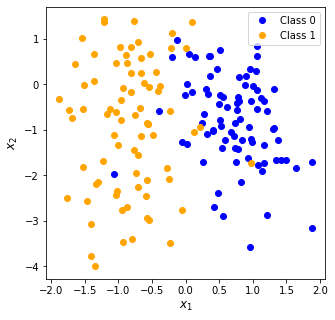

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0, 
                           n_informative=2, n_clusters_per_class=1, 
                           flip_y=0.05, class_sep=0.8, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, 
                                                   random_state=1)
plt.figure(figsize=(5,5))
plt.plot(X_train[y_train==0,0],X_train[y_train==0,1], "bo", label="Class 0" )
plt.plot(X_train[y_train==1,0],X_train[y_train==1,1], "o", color="orange", label="Class 1" )
plt.xlabel(r"$x_1$", fontsize=12)
plt.ylabel(r"$x_2$", fontsize=12)
plt.legend()
plt.show()

### 3.1 Model Estimates 

`LogisticRegression` is in the `sklearn.linear_model` module of scikit-learn. By default, the function performs $l_2$ regularization (Ridge penalty). We will explore this functionality later; for the moment, we are interested in training the model without regularization. Thus, we will set `penalty='none'` when initializing it. 

In [3]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(penalty='none')
lr_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The vector of the parameters $\mathbf{w} = [w_1,w_2]$ can be retrieved via: 

In [4]:
w = [lr_model.coef_[0][i] for i in range(X_train.shape[1])]
w = np.array(w)
w

array([-4.94797824, -0.18705931])

While the intercept term is: 

In [5]:
intercept = lr_model.intercept_[0]
intercept

-0.41894499328415546

Model coefficients are clearly telling us that feature 1 ($x_1$), is much more important than ($x_2$) at separating the classes, as the absolute value of its coefficient is much larger. This can be also noticed from the plot of the dataset shown above, in which we notice that the classes seem to be more separated "vertically" than horizontally, or diagonally. We can obtain the value of the decision function for each (train/test) unit; let's calculate it for the first test unit: 

In [6]:
# Decision function for first test unit : f(x_i)
np.dot(np.r_[(intercept, w)], np.r_[(1, X_test[0])])

3.2386666869462823

This can also be obtained with the `decision_function` method of LogisticRegression: 

In [7]:
# Decision function for first test unit : w(^T)x_i
lr_model.decision_function(X_test[0].reshape(1,-1))

array([3.23866669])

This value is positive; we expect this unit to belong to the positive class. With what confidence? We can inspect this by calculating the related probability: 

In [8]:
sigmoid( np.dot(np.r_[(intercept, w)], np.r_[(1, X_test[0])]) )  

0.9622637237241819

Equivalently, scikit-learn calculates the same probability for us: 

In [9]:
lr_model.predict_proba(X_test[0].reshape(1,-1))

array([[0.03773628, 0.96226372]])

In this case, two probabilities are returned: the first is the probability to belong to the negative class; and the second is the probability to belong to the positive class (you can check that the two numbers sum indeed to 1). This can be confirmed by checking how scikit-learn sorts the classes: 

In [10]:
lr_model.classes_

array([0, 1])

Therefore, in the first position we have the elements for "Class 0" and in the second position the elements for "Class 1". Last, let's obtain the predicted probabilities for the first ten units in the training set: 

In [11]:
lr_model.predict_proba(X_train[:5])

array([[0.03402446, 0.96597554],
       [0.00813653, 0.99186347],
       [0.15213048, 0.84786952],
       [0.05656707, 0.94343293],
       [0.75327352, 0.24672648]])

The first four units have a higher probability to belong to Class 1; the fifth unit has a higher probability to belong to Class 0, according to the logistic regression model. 

What's the model accuracy on the training/test data? We can assess this with the `score` method (as seen in previous lectures). 

In [12]:
# Training set accuracy 
lr_model.score(X_train, y_train)

0.9375

In [13]:
# Test set accuracy 
lr_model.score(X_test, y_test)

0.95

Of course, as seen in the "Model Performance" lecture, other metrics are possible (such as confusion matrix, AUC, $f_1$ score, etc.) You can find them in the `metrics` module of scikit-learn.  

### 3.2 Predictions and decision boundaries 

We have seen how to obtain the probabilies to belong to each class with the `predict_proba` method. scikit-learn performs the predictions by assigning each unit to the class that has largest probability (in the two-class case, this is the class with probability larger than 0.5). Let's do it 'manually', before doing it with the scikit-learn function. As done above, let's consider the first five instances of the training dataset: 

In [14]:
probs_five_units = lr_model.predict_proba(X_train[:5])
pred_five_units = np.array([np.argmax(x) for x in probs_five_units])
np.c_[(probs_five_units, pred_five_units)]

array([[0.03402446, 0.96597554, 1.        ],
       [0.00813653, 0.99186347, 1.        ],
       [0.15213048, 0.84786952, 1.        ],
       [0.05656707, 0.94343293, 1.        ],
       [0.75327352, 0.24672648, 0.        ]])

Equivalently, we can also perform the prediction considering the decision function (dot product of $\mathbf{w}$ and $\mathbf{x}_i$, plus the bias term): 

In [15]:
dec_func_five_units = lr_model.decision_function(X_train[:5])
pred_five_units_2 = np.array([np.where(x >= 0.0,1,0) for x in dec_func_five_units])
np.c_[(dec_func_five_units, pred_five_units_2)]

array([[ 3.34605899,  1.        ],
       [ 4.80322142,  1.        ],
       [ 1.71798822,  1.        ],
       [ 2.81409834,  1.        ],
       [-1.11614805,  0.        ]])

As seen above, the units in the negative side of the decision boundary belong to the negative class; and vice versa. Let's now make sure that scikit-learn returns our same predictions: 

In [16]:
lr_model.predict(X_train[:5])

array([1, 1, 1, 1, 0])

And the first five units of the test set (using `predict_proba`): 

In [17]:
probs_five_test_units = lr_model.predict_proba(X_test[:5])
pred_five_test_units = np.array([np.argmax(x) for x in probs_five_test_units])
np.c_[(probs_five_test_units, pred_five_test_units)].round(3)

array([[0.038, 0.962, 1.   ],
       [0.142, 0.858, 1.   ],
       [1.   , 0.   , 0.   ],
       [0.999, 0.001, 0.   ],
       [0.429, 0.571, 1.   ]])

In [18]:
lr_model.predict(X_test[:5])

array([1, 1, 0, 0, 1])

Last, because we are using a dataset with two features, we can visualize the decision boundary graphically: 

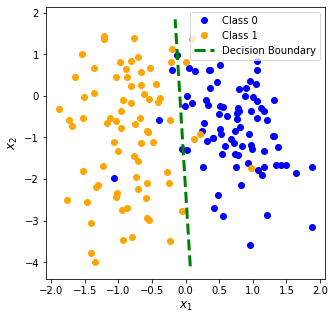

In [19]:
x2_range = np.linspace(X[:,1].min()-0.1, X[:,1].max()+0.1, 100)
dec_bound = (-intercept/w[0]) + (-w[1]/w[0]) * x2_range


plt.figure(figsize=(5,5))
plt.plot(X_train[y_train==0,0], X_train[y_train==0,1], 
        "bo", label="Class 0")
plt.plot(X_train[y_train==1,0], X_train[y_train==1,1], 
        "o", color="orange", label="Class 1")
plt.plot(dec_bound, x2_range, "g--", linewidth=3, label="Decision Boundary")
plt.xlabel(r"$x_1$", fontsize=12)
plt.ylabel(r"$x_2$", fontsize=12)
plt.legend(loc=1)
plt.show()

We can also plot the contour of the predicted probabilities: 

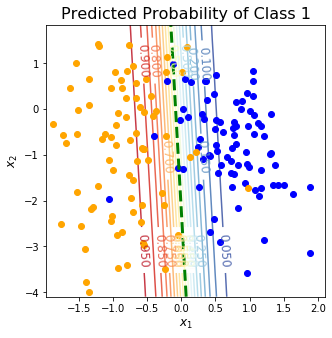

In [20]:
x1_range = np.linspace(X[:,0].min()-0.1, X[:,0].max()+0.1, 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
prob_grid = lr_model.predict_proba(np.c_[xx1.ravel(), xx2.ravel()])[:,1]
prob_grid = prob_grid.reshape(xx1.shape)

f, ax = plt.subplots(figsize=(5, 5))
contour = ax.contour(xx1, xx2, prob_grid, 20, cmap="RdYlBu_r",
                      vmin=0, vmax=1, alpha=0.85)
plt.clabel(contour, inline=1, fontsize=12)
plt.plot(X_train[y_train==0,0], X_train[y_train==0,1], 
        "bo", label="Class 0")
plt.plot(X_train[y_train==1,0], X_train[y_train==1,1], 
        "o", color="orange", label="Class 1")
plt.plot(dec_bound, x2_range, "g--", linewidth=3, label="Decision Boundary")
plt.title("Predicted Probability of Class 1", fontsize=16)
plt.xlabel(r"$x_1$", fontsize=12)
plt.ylabel(r"$x_2$", fontsize=12)
# Uncomment to view colorbar
# ax_c = f.colorbar(contour)
# ax_c.set_label("$\Pr(Class\ =\ 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])
plt.show()

A similar plot can be drawn using the `decision_function`. 

### 3.3 Model Interpretation 
Let's see again the intercept and coefficients of the model: 

In [21]:
(intercept, w[0], w[1])

(-0.41894499328415546, -4.947978240883858, -0.18705931166618447)

How should we interpret them? 

* The intercept is the expected log-odds ratio in favor of Class 1 over Class 0 when all the features are equal to zero (if exponentiated, it is the expected odds-ratio); when transformed with the sigmoid function, it tells us the "expected probability" to observe the positive class when no other information is used as input; in this case: 

In [22]:
sigmoid(intercept)

0.3967692315176172

When the model is estimated with dummy/one-hot encoded variables excluding a baseline category, this is the expected probability to belong to the positive class for the baseline.

* The other coefficients denote how much the decision function changes, as we increase the corresponding feature by 1 unit *while keeping all other features constant*. These coefficients can also be used to measure *feature importance* (and this is what transformers such as `SelectFromModel` do in scikit-learn), in which case you should consider their absolute values. Now, remember that according to the logit function:<br> $$ w_0+\mathbf{w}^T\mathbf{x}_i = log\left(\frac{\sigma(w_0+\mathbf{w}^T\mathbf{x}_i)}{1-\sigma(w_0+\mathbf{w}^T\mathbf{x}_i)}\right) $$ <br> which means that <br> $$e^{w_0+\mathbf{w}^T\mathbf{x}_i} = \frac{\sigma(w_0+\mathbf{w}^T\mathbf{x}_i)}{1-\sigma(w_0+\mathbf{w}^T\mathbf{x}_i)}$$ <br> that is the *odds-ratio* of the probability to belong to the positive vs. negative class. A value of such ratio equal to 1 means that the two classes have the same probability; the larger this ratio, the higher the probability for the unit to belong to class 1; the closer is this ratio to 0, the higher the probability for the unit to belong to class 0. We have seen above that the value of the log-odds ratio for the first test unit was about 3.239; the corresponding odds-ratio is:  

In [23]:
np.exp(3.239)

25.508200788210488

Which means this unit is 25 times more likely to belong to the positive than the negative class; in other words, the model is very confident to classify such unit in the positive class. 
Let's now consider our example with $f(\mathbf{x}_i) = w_0 + w_1x_{i1}+w_2x_{i2}$. Here, $w_1$ can be interpreted as the *expected change in odds-ratio* as we increase $x_1$ by one unit, while holding all other features constant. This is because: 

<br>
$$ \frac{e^{w_0 + w_1(x_{i1} + 1)+w_2x_{i2}}}{e^{w_0 + w_1x_{i1}+w_2x_{i2}}} = e^{w_1}$$ 
<br>
In our example: 

In [24]:
np.exp(w[0])

0.0070977443621410416

that means we expect a strong decrease (times 0.007) in the odds to belong to the positive class (since the value is smaller than 1), as we observe an increase of $x_1$ by one unit while holding $x_2$ constant. This makes sense, as the value of $w_1$ is negative, strongly shifting the odds towards the negative class. (Try to answer this question without performing any calculation: do you expact the increase in odds to be more or less in favor of the positive class for $w_2$? Try to answer intuitively, and then check your intuition with `np.exp(w[1])`). 

* `scikit-learn` is a library for Machine Learning, rather than Statistics. Therefore, it doesn't output the statistical significance of each coefficient. If you want to fit a logistic model and observe standard errors and p-values of the coefficients, you should use the module for [Generalized Linear Models](https://www.statsmodels.org/dev/glm.html) of the `statsmodels` library. 

## 4. Model Regularization

As you have seen in previous lectures, *regularization* helps to tune the complexity of the model by adding a penalty term to the objective function to optimize. There are several ways to regularize linear/logistic regression models. Here, we will see how to apply the following regularization techniques with scikit-learn: 

* ridge penalty
* lasso penalty 

### 4.1 Ridge Logistic Regression 
Consider the following dataset: 

In [25]:
data_imp = pd.read_csv("./data/logistic_regression/ridge_lr_example.csv")

In [26]:
X = data_imp.drop("y", axis=1)
y = data_imp["y"]
X.shape

(199, 200)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# We retain 10% of the instances for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, 
                                                   random_state=1)
# We scale the features with standardization (for resons that will become clear in a bit): 
standardizer = StandardScaler()
X_train_scaled = standardizer.fit_transform(X_train)
X_test_scaled = standardizer.transform(X_test)

What happens when we estimate a 'unregularized' (that is, without penalty, unrestricted) LR model? Let's compare the accuracy on the training and test set, as well 5-fold-cross-validation accuracy. 

In [28]:
from sklearn.model_selection import cross_val_score
log_reg_unrestricted = LogisticRegression(penalty="none")
log_reg_unrestricted.fit(X_train_scaled, y_train)
print("Accuracy on training set:{:.2f}".format(log_reg_unrestricted.score(X_train_scaled, y_train)))
print("CV score:{:.2f}".format(cross_val_score(log_reg_unrestricted, X_train_scaled,y_train, cv=5).mean()))
print("Test score:{:.2f}".format(log_reg_unrestricted.score(X_test_scaled, y_test)))

Accuracy on training set:1.00
CV score:0.75
Test score:0.70


The model is clearly overfitting, and therefore too complex! This can happen because the model is unconstrained, learning coefficients that are too 'suited' to the training data, leading to a high-variance model and therefor not generalizing well. Introducing the ridge penalty is a way to overcome these problems, as the coefficients of the model (included in the vector $\mathbf{w}$) are shrunk towards a value of $0$ (reducing in this way the variance of the model - but increasing its bias!). In ridge regression, the penalty term applies to the square of the *Euclidean Norm* (a.k.a. $l_2$ norm) of $\mathbf{w}$. Such penalty is defined as $||\mathbf{w}||_2^2 = \mathbf{w}^T\mathbf{w} = \sum_{j=1}^{p} w_j^2$ (note that the intercept is not penalized). We see that the norm puts a penalty on the squares of the weights, encouraging the model to favor smaller values. In order to regulate the strength of the penalty, the norm is multiplied by a value $\lambda \geq 0 \in \mathbb{R}$. The optimal $\lambda$ can be tuned, for example, by means of cross-validation. 

The new objective function to minimize thus now becomes: 

$$\tilde{\mathbf{w}}^{opt} =\min_{\tilde{\mathbf{w}}}\ \mathcal{nll}(\tilde{\mathbf{w}})\ + \lambda\left(\mathbf{w}^T\mathbf{w}\right) $$

or, equivalently, 

$$\tilde{\mathbf{w}}^{opt} =\min_{\tilde{\mathbf{w}}}\ \mathbf{w}^T\mathbf{w} \ + C\cdot\mathcal{nll}(\tilde{\mathbf{w}}) $$

where $C=\frac{1}{\lambda}$ (also $ \geq 0$) is the *inverse of the regularization strength*. (Notice that the objective is in the form Regularizer + Loss: we will encounter this type of problems again during the course). The two optimization problems just outlined are equivalent; in the second one, we obtain more penalized solutions (that is, coefficients closer to 0) when we decrease $C$, and we obtain more unconstrained solutions as we increase it towards $+\infty$ (while the opposite is true when using $\lambda$); indeed, when increasing $C$ we allow for larger values in the objective function. Notice that this is equivalent to the optimization problem [used in scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) (in the scikit-learn page the intercept term is called $c$, while in our formualtion it is embedded in the vector $\tilde{\mathbf{w}}$).

In [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), the Ridge Penalty is set by default (`penalty='l2'` in the corresponding argument), and the (inverse of) regularization strength can be changed with the hyperparameter `C` (set equal to 1.0 by default). First, let's make sure that a large value of `C` leads indeed to the same results of a unrestricted model. 

**Note**: before performing ridge regression, or any other form of regularization, it is important to scale the features first, as features observed under different scales might receive a different amount of penalty! This is why we have rescaled the features above. 

In [29]:
log_reg_unrestricted_2 = LogisticRegression(penalty="l2", C=1000000000)
log_reg_unrestricted_2.fit(X_train_scaled, y_train)
print("Accuracy on training set:{:.2f}".format(log_reg_unrestricted_2.score(X_train_scaled, y_train)))
print("CV score:{:.2f}".format(cross_val_score(log_reg_unrestricted_2, X_train_scaled,y_train, cv=5).mean()))
print("Test score:{:.2f}".format(log_reg_unrestricted_2.score(X_test_scaled, y_test)))

Accuracy on training set:1.00
CV score:0.75
Test score:0.70


Let's now see what happens in the opposite extreme, that is, when `C` is very small: 

In [30]:
log_reg_too_simple = LogisticRegression(penalty='l2', C=1e-4, max_iter=1e+05)
log_reg_too_simple.fit(X_train, y_train)
print("Accuracy on training set:{:.2f}".format(log_reg_too_simple.score(X_train_scaled, y_train)))
print("CV score:{:.2f}".format(cross_val_score(log_reg_too_simple, X_train_scaled,y_train, cv=5).mean()))
print("Test score:{:.2f}".format(log_reg_too_simple.score(X_test_scaled, y_test)))

Accuracy on training set:0.55
CV score:0.55
Test score:0.55


In this case, the model is clearly underfitting: it shrinks the coefficients too much, and it is not able to learn an optimal separating hyperplane from the training data. Let's now find an optimal value for 'C' by using 5-fold cross-validation: 

In [31]:
from sklearn.model_selection import GridSearchCV
# Search across a grid of 100 equi-distant values in the log-space between 1e-4 and 20
param_grid = {'C': np.exp( np.linspace(np.log(1e-4), np.log(20), 100) ) }
clf = GridSearchCV(LogisticRegression(penalty='l2', max_iter=1e+07), param_grid, cv=5, n_jobs=-1)
clf.fit(X_train_scaled, y_train)
print("Done")

Done


In [32]:
# Best CV accuracy: 
clf.best_score_

0.8050793650793651

As we can notice, regularizing has improved the CV accuracy to 80.5%. 

In [33]:
# Best C value: 
clf.best_params_

{'C': 0.022699345303073458}

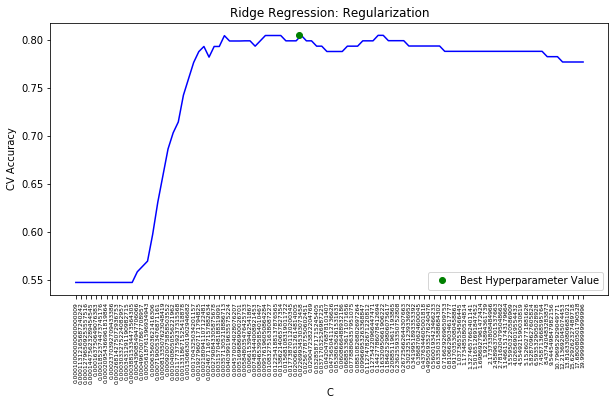

In [34]:
cv_res = pd.DataFrame(clf.cv_results_).sort_values(by="param_C")
plt.figure(figsize=(10,5))
x_ax = np.linspace(0, cv_res.shape[0], cv_res.shape[0])
plt.plot(x_ax, cv_res["mean_test_score"], "b-")
plt.plot(cv_res["mean_test_score"].idxmax(),clf.best_score_, "go", label="Best Hyperparameter Value")
plt.xticks(x_ax, (cv_res["param_C"]).astype("float64").round(20), rotation=90, fontsize=6)
plt.xlabel("C")
plt.ylabel("CV Accuracy")
plt.title("Ridge Regression: Regularization")
plt.legend(loc=4)
plt.show()

The best accuracy has been reached for three distinct C values:

In [35]:
cv_res.loc[np.where(cv_res['mean_test_score']==clf.best_score_)[0], ["param_C","mean_test_score"]]

,param_C,mean_test_score
44,0.0226993,0.805079
59,0.144278,0.805079
60,0.16321,0.805079


In this case, scikit-learn has chosen the minimum C which leads to best accuracy; the benefit of this is that such value produces the simplest models among the three best performing ones. This might not always be the case (depending on whether the complexity parameter is sorted in increasing or decreasing order), so you should always check the value picked by scikit-learn. Let's now check the training and test error: 

In [36]:
clf.best_estimator_.score(X_test_scaled,y_test)

0.8

Which is about 10% improvement w.r.t. the unconstrained logistic regression (with a much simpler model!). Last, let's compare the first 50 coefficients returned by ridge logistic regression vs. the unpenalized model: 

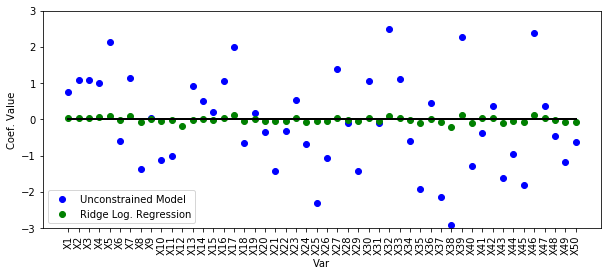

In [37]:
plt.figure(figsize=(10,4))
max_var = 50
x_ax = np.linspace(0, max_var, max_var)
plt.plot(x_ax, log_reg_unrestricted.coef_[0, :max_var], "bo", label="Unconstrained Model")
plt.plot(x_ax, clf.best_estimator_.coef_[0, :max_var], "go", label="Ridge Log. Regression")
plt.plot(x_ax, np.repeat(0, max_var), "k-", linewidth=2)
plt.xlabel("Var")
plt.ylabel("Coef. Value")
plt.xticks(x_ax, X.columns[:max_var], rotation=90)
plt.ylim(-3, 3)
plt.legend()
plt.show()

It is clearly visible that the coefficients estimated by ridge logistic regression are much closer to 0 than those estimated without penalty. 

### 4.2 Lasso Penalty 
A problem with ridge regression is that it doesn't set the coefficients of features that are not significant for prediction exactly equal to 0, and therefore it is not the best tool to perform feature selection. An alternative penalty that does this is the *lasso* penalty. This is also called $l_1$ regularization, as it performs the shrinkage of the coefficients in their $L_1$ norm, defined as $||\mathbf{w}||_1 = \sum_{j=1}^{p}|w_j|$. Unlike the $l_2$ penalty, lasso performs the shrinkage using the absolute value of the coefficients, and this modification is enough to allow the optimizer to set some of the model parameters to $0$. Lasso penalty is a very useful tool for model selection *in the linear space of the features* (it is a common choice to use it in combination with `SelectFromModel` in scikit-learn). The new optimization problem now is: 


$$\tilde{\mathbf{w}}^{opt} =\min_{\tilde{\mathbf{w}}}\ ||\mathbf{w}||_1 \ + C\cdot\mathcal{nll}(\tilde{\mathbf{w}}) $$

In scikit-learn, the lasso penalty for Logistic Regression can be set with `penalty='l1'`; as seen for the ridge case, higher `C` values mean less regularization, while lower `C` values will set more coefficients equal to 0. In this case, it is important to set `solver='liblinear'` to perform the training (use `solver='saga'` instead when you work with a large dataset). Last, as seen in the previous section, it is important to scale the features also when working with the lasso penalty. 

In [38]:
data_imp = pd.read_csv("./data/logistic_regression/lasso_lr_example.csv")

In [39]:
X = data_imp.drop("y", axis=1)
y = data_imp["y"]
X.shape

(500, 50)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# We retain 20% of the instances for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, 
                                                   random_state=1)
standardizer = StandardScaler()
X_train_scaled = standardizer.fit_transform(X_train)
X_test_scaled = standardizer.transform(X_test)

As done earlier, let's first train a non-penalized LR model on this dataset: 

In [41]:
log_reg_unrestricted = LogisticRegression(penalty="none")
log_reg_unrestricted.fit(X_train_scaled, y_train)
print("Accuracy on training set:{:.2f}".format(log_reg_unrestricted.score(X_train_scaled, y_train)))
print("CV score:{:.2f}".format(cross_val_score(log_reg_unrestricted, X_train_scaled,y_train, cv=5).mean()))
print("Accuracy on test set:{:.2f}".format(log_reg_unrestricted.score(X_test_scaled, y_test)))

Accuracy on training set:0.84
CV score:0.78
Accuracy on test set:0.72


We suspect that not all features are useful to perform prediction; unfortunately, we cannot perform feature selection by evaluating the coefficients of the unregularized model: 

In [42]:
log_reg_unrestricted.coef_

array([[-7.81907215e-01,  3.20235157e-01,  6.64842465e-01,
         8.07552378e-01,  3.00616900e-02,  7.45443555e-01,
        -7.82764330e-01, -4.00794170e-04,  6.91876378e-01,
        -8.77883086e-01,  7.67326242e-01, -2.00125299e-01,
         2.81016348e-01, -7.37146714e-01,  5.78736715e-02,
         1.27086015e-01, -1.25833301e+00,  5.45330035e-01,
         8.47906423e-02, -5.24700389e-01,  1.35863322e-01,
         2.52867769e-01, -1.09046821e-01, -5.40242112e-02,
        -8.65126685e-02, -2.06722101e-01, -1.36386822e-01,
         2.65044772e-01, -2.41756065e-01, -3.88048995e-02,
        -1.03847669e-01,  5.53204676e-02,  3.33342013e-01,
        -6.79865341e-02,  1.22410935e-02,  1.26835820e-02,
         6.01167174e-03,  1.84695920e-01, -2.39693294e-01,
         3.42024488e-01, -1.53094043e-01, -9.28224648e-02,
         4.45131682e-03,  3.37828228e-01, -6.13693053e-02,
        -1.31982465e-01, -4.81392942e-02,  1.16325962e-01,
         1.72368257e-01, -3.33623072e-01]])

We now tune a LR model with lasso penalty:

In [43]:
from sklearn.model_selection import GridSearchCV
# Search across a grid of 100 equi-distant values in the log-space between 1e-2 and 20
param_grid = {'C': np.exp( np.linspace(np.log(1e-2), np.log(20), 100) ) }
clf = GridSearchCV(LogisticRegression(penalty='l1', max_iter=1e+07, solver='liblinear'), 
                   param_grid, cv=5, n_jobs=-1)
clf.fit(X_train_scaled, y_train)
print("Done")

Done


In [44]:
# Best CV accuracy: 
clf.best_score_

0.7874999999999999

In [45]:
# Best C value: 
clf.best_params_

{'C': 0.46471518800784045}

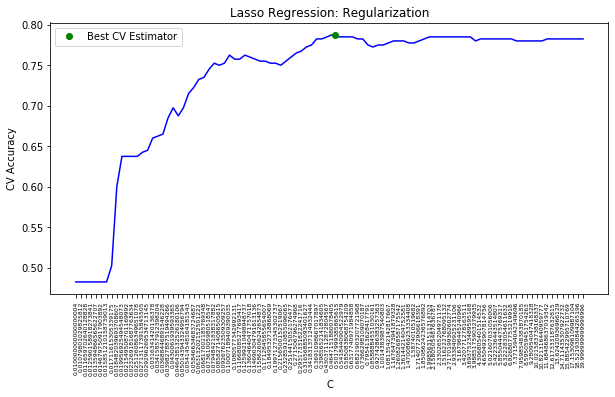

In [46]:
cv_res = pd.DataFrame(clf.cv_results_).sort_values(by="param_C")
plt.figure(figsize=(10,5))
x_ax = np.linspace(0, cv_res.shape[0], cv_res.shape[0])
plt.plot(x_ax, cv_res["mean_test_score"], "b-")
plt.plot(cv_res["mean_test_score"].idxmax()+1,clf.best_score_, "go", label="Best CV Estimator")
plt.xticks(x_ax, (cv_res["param_C"]).astype("float64").round(20), rotation=90, fontsize=6)
plt.xlabel("C")
plt.ylabel("CV Accuracy")
plt.title("Lasso Regression: Regularization")
plt.legend(loc=2)
plt.show()

In [47]:
clf.best_estimator_.score(X_test_scaled,y_test)

0.73

Thus, the score on the test set is 1% higher than the unconstrained mode, while using fewer features for prediction: 

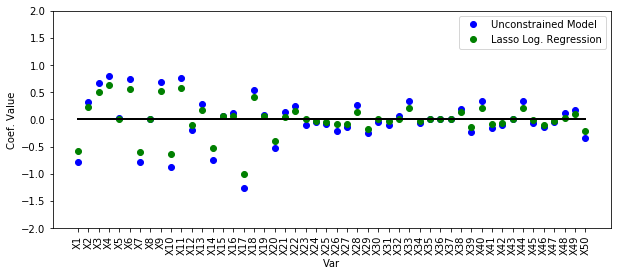

In [48]:
plt.figure(figsize=(10,4))
x_ax = np.linspace(0, X_train.shape[1], X_train.shape[1])
plt.plot(x_ax, log_reg_unrestricted.coef_[0], "bo", label="Unconstrained Model")
plt.plot(x_ax, clf.best_estimator_.coef_[0], "go", label="Lasso Log. Regression")
plt.plot(x_ax, np.repeat(0, X_train.shape[1]), "k-", linewidth=2)
plt.xlabel("Var")
plt.ylabel("Coef. Value")
plt.xticks(x_ax, X.columns[:max_var], rotation=90)
plt.ylim(-2,2)
plt.legend()
plt.show()

Let's check the coefficient values: 

In [49]:
np.c_[(X_train.columns, clf.best_estimator_.coef_[0])]

array([['X1', -0.5877479093189079],
       ['X2', 0.23371782185947668],
       ['X3', 0.49660859986566036],
       ['X4', 0.6356673896505657],
       ['X5', 0.0013616596857179255],
       ['X6', 0.5601904137008146],
       ['X7', -0.6061417794146072],
       ['X8', 0.0],
       ['X9', 0.5219941294896093],
       ['X10', -0.638355926402124],
       ['X11', 0.5707999025608391],
       ['X12', -0.11115107404354042],
       ['X13', 0.1750063611981238],
       ['X14', -0.5310705595135934],
       ['X15', 0.06561907262260341],
       ['X16', 0.06533277404775914],
       ['X17', -0.9979509263607961],
       ['X18', 0.4125261802804399],
       ['X19', 0.05599424587404494],
       ['X20', -0.3945788423232709],
       ['X21', 0.04854854264413216],
       ['X22', 0.16389434384846083],
       ['X23', 0.0],
       ['X24', -0.03636397890641952],
       ['X25', -0.04223873978393156],
       ['X26', -0.08325484817036169],
       ['X27', -0.08846174177621975],
       ['X28', 0.140258114918012],
       

Thus, the following variables are not used for predictions by lasso ridge regression: 

In [50]:
X_train.columns[clf.best_estimator_.coef_[0]==0]

Index(['X8', 'X23', 'X30', 'X35', 'X36', 'X37', 'X43'], dtype='object')

### 4.3 Other remarks on Regularized Logistic Regression 
* The ridge penalty can be beneficial when dealing with datasets having more features than observations ($p>n$ case), and/or in presence of linearly correlated features ("multicollinearity"), as it decreases the model's *degrees of freedom* 
* There is another regularization technique, called 'elastic net', that combines ridge and lasso; in the logistic regression model of scikit-learn you can use it by setting the options `penalty='elasticnet'`, `solver='saga'`. In this case you have two hyperparameters to tune: `C`, which controls the amount of regularization, and `l1_ratio` (between 0 and 1) which balances the $l_1$ vs. $l_2$ regularization (for example, `l1_ratio=0` is equivalent to ridge regression; `l1_ratio=1` is equivalent to lasso regression; and values in the middle try to weight the two penalties). Such penalty is useful in all cases where the ridge penalty is useful (multicollinearity, etc.), but we also want to perform feature selection. In Section 7 below, you will see an example of elastic-net applied to the Heart Dataset. Note: with `solver=saga` you should also set the `random_state` for reproducibility; see the sklearn documentation page
* scikit-learn also provides [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html), which can be faster than `LogisticRegression` with $l_2$ penalty in the multi-class case (with RidgeClassifier, the penalty term `alpha` works in the oppositve way of `C`: the larger `alpha` is, the more the model is regularized)
* If you have doubts about which penalty to use, remember that you can tune the hyperparameter `penalty` as well by including it in the parameter grid of GridSearchCV. For example you can set a grid similar to the following one: <br> ```param_grid = {'penalty': ['l1','l2'], 'C': np.exp( np.linspace(np.log(1e-2), np.log(20), 100))}``` or even with penalty-specific values of C
* Once again, remember to scale the features before performing any sort of regularization! 
* You can use one-hot encoding with all categories (including the baseline) when working with regularized linear models (exclude the baseline if you are using linear models without regularization!)

## 5. Multi-Class Case

We have already seen in previous lectures that classification with several classes  ($C>2$; don't confuse the $C$ used here to denote the number of classes with the regularization parameter just encountered!) can be performed with two approaches: 
* One-versus-All (a.k.a. One-Versus-Rest, OvR) where we train as many models as there are classes, each time considering a new class as the positive one
* One-versus-one where we train the models with two classes at a time, and we consider all possible pairs of classes

In both cases, a set of binary LR models is learned, obtaining in this way different parameter estimates. In particular, in the OvR approach there are as many sets of parameters ($[w_0,\mathbf{w}]$ vectors) as the number of classes. To convert the class-specific decision functions into probabilities, we use the *softmax function*: 

$$\Pr(y_i=c|\mathbf{x}_i)=p_{i,c}=softmax(w_{0,c}, \mathbf{w}_c, \mathbf{x}_i)= \frac{e^{w_{0,c}+\mathbf{w}^T_c\mathbf{x}_i}}{\sum_{k=1}^{C}e^{w_{0,k}+\mathbf{w}^T_k\mathbf{x}_i}}$$

where $w_{0,c}, \mathbf{w}_c$ are the intercepts and coefficients estimated for the model of the $c$-th class. The observations are then predicted to the class that maximizes $softmax(w_{0,c}, \mathbf{w}_c, \mathbf{x}_i)$ or, equivalently, that maximizes $f_c(\mathbf{x}_i) = w_{0,c}+\mathbf{w}^T_c\mathbf{x}_i$.   


Alternatively, some classifiers can work directly with more than two classes. This happens to be the case for the logistic regression model; instead of the Binomial distribution, the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) is maximized in this case. The Multinomial distribution is the extension of the Binomial to more than two categories. If we consider the likelihood of such distribution, and take its negative logarithm (as done in the binary case above), we obtain the *cross-entropy*, which -once rescaled by the training sample size, $n$- becomes the new loss function to minimize: 

$$ L(\mathbf{w}) =  -\frac{1}{n}\sum_{i=1}^{n}\sum_{c=1}^{C}{y_{i,c}}log\left(\hat{p}_{i,c}\right)  $$

where $\hat{p}_{i,c}=\Pr(y_{i,c}=1|\mathbf{x}_i)=softmax\left(w_{0,c}, \mathbf{w}_c,\mathbf{x}_i\right)$ is the estimated probability of class $c$ and $y_{i,c}$ is the $c$-the element of a $C$-dimensional output vector equal to 1 when unit $i$ is in class $c$, and 0 otherwise. In practice, the output variable is one-hot encoded before estimating the algorithm (once again, this is done internally in scikit-learn). The gradient of $L(\mathbf{w})$ w.r.t. the set of coefficients in the $c$-th class, $\tilde{\mathbf{w}}_c = [w_{0,c}, \mathbf{w}_c]$, is: 

$$ \nabla_{\tilde{\mathbf{w}}_c} L(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^{N}\left(\hat{p}_{i,c}-y_{i,c}\right)\tilde{\mathbf{x}}_i
$$

Here, $\tilde{\mathbf{x}}_i$ is defined as we did in the binary binomial regression section. Once again, we can use gradient descent, or (by deriving second-order derivatives) Newton-Rhapson to find the otpimal solution. Data points are predicted to the class $c$ that maximizes $\hat{p}_{i,c}$ (or, which is equivalent, $f_c(\mathbf{x}_i) = w_{0,c}+\mathbf{w}^T_c\mathbf{x}_i$). 

***

In this section, we are going to explore the output provided by scikit-learn with the multinomial model and the OvR approach.

### 5.1 Toy Dataset
We are going to generate an example with four classes and two features in order to ease visualization. As done above, we are going to use `make_classification` from the scikit-learn library. 

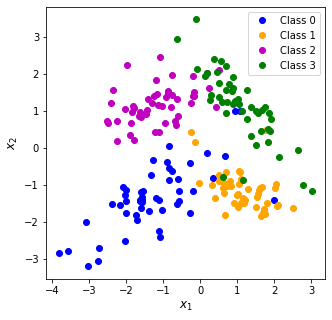

In [51]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
# n=240 instances
X, y = make_classification(n_samples=240, n_features=2, n_redundant=0, 
                           n_informative=2, n_clusters_per_class=1, n_classes=4, 
                           flip_y=0.05, class_sep=1.2, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, 
                                                   random_state=1)
plt.figure(figsize=(5,5))
plt.plot(X_train[y_train==0,0],X_train[y_train==0,1], "bo", label="Class 0" )
plt.plot(X_train[y_train==1,0],X_train[y_train==1,1], "o", color="orange", label="Class 1" )
plt.plot(X_train[y_train==2,0],X_train[y_train==2,1], "mo", label="Class 2" )
plt.plot(X_train[y_train==3,0],X_train[y_train==3,1], "go", label="Class 3" )
plt.xlabel(r"$x_1$", fontsize=12)
plt.ylabel(r"$x_2$", fontsize=12)
plt.legend()
plt.show()

## 5.2 multi_class = 'multinomial' 
We now train a logistic regression model on this dataset, by maximizing the parameters of the multinomial distribution; in order to do so, we need to set `multi_class='multinomial'` (notice that we won't specify any penalty, which means that $l_2$ regularization with $C=1$ is set by default; therefore, we will standardize the features first):

In [52]:
standardizer = StandardScaler()
X_train_st = standardizer.fit_transform(X_train)
X_test_st = standardizer.transform(X_test)
multi_lr = LogisticRegression(multi_class='multinomial')
multi_lr.fit(X_train_st, y_train)
# Obtain decision function for first five training unit
multi_lr.decision_function(X_train_st[:5])

array([[  7.80372538,   0.6402735 ,   2.46402513, -10.90802401],
       [  1.35572831,   2.81636467,  -3.28143292,  -0.89066007],
       [ -1.41177674,  -1.14921368,   0.9345383 ,   1.62645213],
       [  1.34997805,   1.72290285,  -1.79266536,  -1.28021554],
       [ -2.29239567,  -0.96651267,   0.30601069,   2.95289766]])

As we can see, the decision function has now as many values as there are classes; the first row, for example, is telling us that the first training unit lies (according to the model) well inside the portion of hyperplane reserved to the first class (Class 0). This is because the largest value of the decision function for the first training instance corresponds to the one of Class 0. Let's convert such values into probabilities with the softmax function:  

In [53]:
softmax( multi_lr.decision_function(X_train_st[0].reshape(1,-1))[0] ).round(3)

array([0.994, 0.001, 0.005, 0.   ])

Thus, the first trainign instance has 99.4% probability to belong to Class 0, and only 0.1% to belong to Class 1 and 0.5% to belong to Class 2. We can also retrieve such probabilities with scikit-learn; let's do it for the first 5 units in the training set:

In [54]:
multi_lr.predict_proba(X_train_st[:5]).round(3)

array([[0.994, 0.001, 0.005, 0.   ],
       [0.184, 0.794, 0.002, 0.02 ],
       [0.03 , 0.039, 0.311, 0.621],
       [0.39 , 0.566, 0.017, 0.028],
       [0.005, 0.018, 0.065, 0.912]])

As you can see, all probabilities sum to 1. Let's do the same for the first 5 units in the test set:

In [55]:
multi_lr.predict_proba(X_test_st[:5]).round(3)

array([[0.003, 0.031, 0.009, 0.957],
       [0.976, 0.007, 0.017, 0.   ],
       [0.153, 0.769, 0.005, 0.073],
       [0.265, 0.654, 0.015, 0.066],
       [0.148, 0.005, 0.845, 0.002]])

We are now going to assess the accuracy on the test set:

In [56]:
multi_lr.score(X_test_st,y_test)

0.9166666666666666

Pretty good! How are the (few) errors made by the model distributed? We can check it with the *confusion matrix* (already discussed in previous lectures): 

<Figure size 360x360 with 0 Axes>

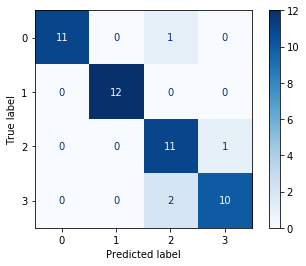

In [57]:
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(multi_lr, X_test_st, y_test, cmap=plt.cm.Blues)
plt.show()

We can see, for example, that instances that belong to Class 1 are all predicted correctly. Let's check the coefficients: 

In [58]:
multi_lr.coef_

array([[-1.46231256, -1.73350446],
       [ 1.16604347, -1.73343693],
       [-2.22018203,  1.61725311],
       [ 2.51645112,  1.84968828]])

The first coefficient (-1.46) is telling us that, as we increase the first feature by one unit while holding constant the second feature, we are decreasing the odds-ratios of belonging to Class 0 by about 23% (as you can notice from the plot of the data points):  

In [59]:
np.exp(-1.46)

0.23223627472975883

Now the intercepts (one for each class): 

In [60]:
multi_lr.intercept_

array([ 0.59451017,  0.22397109, -0.07389668, -0.74458458])

Last, since we are working with just two features, we can plot the decision boundaries and the estimated probabilities (in this case, to belong to Class 1): 

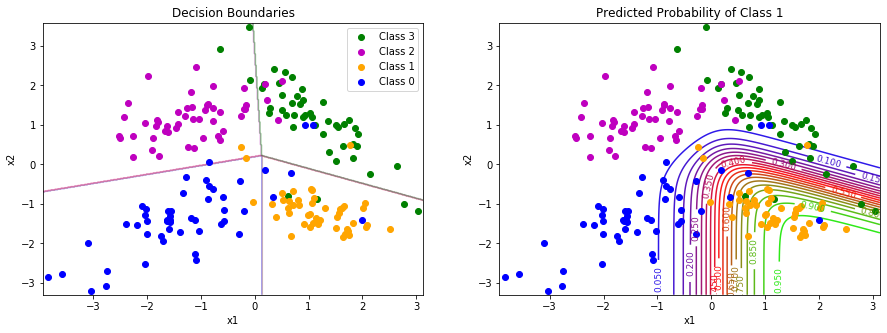

In [61]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['blue','orange','magenta', 'green'])

x0, x1 = np.meshgrid(
        np.linspace(X[:,0].min()-0.1, X[:,0].max()+0.1, 500).reshape(-1, 1),
        np.linspace(X[:,1].min()-0.1, X[:,1].max()+0.1, 500).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = multi_lr.predict_proba(X_new)
y_predict = multi_lr.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(X_train[y_train==3, 0], X_train[y_train==3, 1],  "go", label="Class 3")
plt.plot(X_train[y_train==2, 0], X_train[y_train==2, 1], "mo", label="Class 2")
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], "o", color="orange", label="Class 1")
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], "bo", label="Class 0")
plt.contour(x0, x1, zz, cmap=custom_cmap, alpha=0.25)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Decision Boundaries")
plt.legend()

plt.subplot(122)
plt.plot(X_train[y_train==3, 0], X_train[y_train==3, 1],  "go", label="Class 3")
plt.plot(X_train[y_train==2, 0], X_train[y_train==2, 1], "mo", label="Class 2")
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], "o", color="orange", label="Class 1")
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], "bo", label="Class 0")
contour = plt.contour(x0, x1, zz1, 20, cmap=plt.cm.brg, alpha=0.9)
plt.clabel(contour, inline=1, fontsize=9)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Predicted Probability of Class 1")

plt.show()

### 5.3 multi_class='ovr'
Here, we explore the output of the OvR classifier. (Once again, by default we are implicitly estimating the model(s) with $l_2$ regularization and C=1).

In [62]:
multi_lr = LogisticRegression(multi_class='ovr')
multi_lr.fit(X_train_st, y_train)
# Obtain decision function for first five training unit
multi_lr.decision_function(X_train_st[:5])

array([[  6.72423597,  -3.09488123,  -0.84247026, -15.53481049],
       [ -0.84170202,   0.93703158,  -6.93387955,  -3.71598029],
       [ -4.43388499,  -3.81002283,  -1.09542012,  -0.19140687],
       [ -0.92554859,  -0.50757126,  -5.04948192,  -4.05155429],
       [ -5.47524242,  -3.41074244,  -1.72981104,   1.38654367]])

In this case, the vector of decision functions report the values of the linear predictor, $w_0+\mathbf{w}^T\mathbf{x}_i$, calculated for each single One-vs-Rest model. Such values are automatically transformed into probabilities and normalized by `predict_proba`: 

In [63]:
multi_lr.predict_proba(X_train_st[:5]).round(3)

array([[0.744, 0.032, 0.224, 0.   ],
       [0.288, 0.688, 0.001, 0.023],
       [0.016, 0.029, 0.34 , 0.614],
       [0.416, 0.55 , 0.009, 0.025],
       [0.004, 0.032, 0.153, 0.811]])

The coefficients arrays (and intercepts) too, report the parameters $\mathbf{w}$ for each single model:

In [64]:
multi_lr.coef_

array([[-1.6685092 , -2.19724004],
       [ 1.80352098, -1.98121839],
       [-2.54173073,  2.36226703],
       [ 2.89284132,  2.44485522]])

In [65]:
multi_lr.intercept_

array([-1.93544462, -2.35394385, -2.73729401, -3.22099833])

### 5.4 Lasso Penalty 
Both the multinomial and the OvR models support also lasso penalty, if `solver='saga'` is set (remember to set the `random_state` for reproducibility in this case!). Each class will have its own values of coefficients set to 0 (as different features have different predicting power on different classes). However, the `multinomial` and `ovr` approach won't necessarily lead to the same set of selected coefficients for a given value of `C`; we can see an example on the toy dataset and with C=0.0269. 

In [66]:
multi_lr = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga',
                              random_state=1, C=0.0269)
multi_lr.fit(X_train_st, y_train)
multi_lr.coef_

array([[-0.07152168, -0.1938015 ],
       [ 0.0394215 ,  0.        ],
       [-0.00523392,  0.07876013],
       [ 0.00147591,  0.        ]])

In [67]:
multi_lr = LogisticRegression(multi_class='ovr', penalty='l1', solver='saga', 
                              random_state=1, C=0.0269)
multi_lr.fit(X_train_st, y_train)
multi_lr.coef_

array([[-0.08299083, -0.22091873],
       [ 0.06978676,  0.        ],
       [ 0.        ,  0.1472553 ],
       [ 0.01880736,  0.04014106]])

In the first case (multinomial) feature 2 is removed from the predictors of Class 1 and 3; in the second case (ovr) feature 1 is removed from the set of predictors of Class 2, while feature 2 is removed only for the prediction of Class 1. 

## 6. Logistic Regression: Other Remarks
* Being a linear model, LR is able to find only linear main effects of the predictors (unless interactions or higher degrees polynomials are specified)
* LR is an easily interpretable model, as we just need to interpret the linear coefficients (which can easily be converted into odds-ratios and probabilities)
* As all linear models, it works well in high dimensions, since it can more easily find a hyperplane separating the classes when more features are present 

## 7. Example on the Heart Dataset
In the "Data Preprocessing" notebook we preprocessed the Heart dataset (by imputing its missing values, one-hot encoding the categorical features, and standardizing the continuous ones). As you remember, the goal with such data is to try to predict the presence/absence of heart disease given some clinical and personal information of a sample of patients (such as Age, Sex, Cholesterol level, and so on). We are now going to: 

* load the train/test datasets
* tune an elastic-net penalty on this Data, using10-fold-CV; we will tune the `l1_ratio` hyperparameter including the values 0 and 1, to check whether a Ridge-only or Lasso-only penalties lead to a better accuracy on such dataset 
* evaluate the final model accuracy on the test set 

In [68]:
# 1. Load datasets
data_train = pd.read_csv("./data/heart_data/heart_train_processed.csv")
data_test = pd.read_csv("./data/heart_data/heart_test_processed.csv")
X_train = data_train.drop("y", axis=1)
X_test = data_test.drop("y", axis=1)
y_train = data_train["y"]
y_test = data_test["y"]

In [69]:
# 2a. Prepare parameter Grid for elastic-net 
# For C, we will use a grid of 120 equi-distant values in the log space between 1e-4 and 70
param_grid = {'C': np.exp( np.linspace(np.log(1e-4), np.log(70), 120)), 'l1_ratio':np.linspace(0, 1, 11) }

# 2b. Run GridSearchCV with 10-fold-cv
clf = GridSearchCV(LogisticRegression(penalty='elasticnet', max_iter=1e+07, solver='saga', random_state=1), 
                   param_grid, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print("CV Grid Search: Done")

CV Grid Search: Done


In [70]:
# 3. Check results
clf.best_params_

{'C': 0.1391817007674836, 'l1_ratio': 0.8}

Thus, the best model consists of a mix of $l_2$ regularization (which accounts for 20% of the penalty) and $l_1$ regularization (which accounts for 80% of the penalty), and $C$ equal to (about) 0.139. Let's check the CV estimate of test accuracy:

In [71]:
clf.best_score_

0.8513333333333334

Now, let's plot a *heatmap* of the CV accuracies obtained for each combination of `C` and `l1_ratio`: 

In [72]:
cv_res = pd.DataFrame(clf.cv_results_)
scores = np.array(cv_res.mean_test_score).reshape(120, 11).transpose()

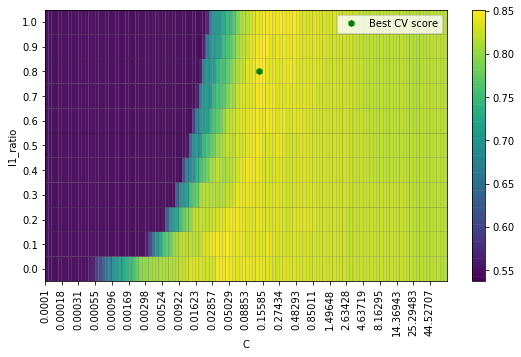

In [73]:
plt.figure(figsize=(9,5))
ax = plt.gca()
img = ax.pcolor(scores, cmap="viridis", edgecolors='k', linewidths=0.1, alpha=.95)
ind = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
plt.plot(ind[1], ind[0]+0.5, "gh", label="Best CV score")
img.update_scalarmappable()
ax.set_ylabel("l1_ratio")
ax.set_xlabel("C")
ax.set_yticks(np.arange(len(param_grid["l1_ratio"])) + .5)
ax.set_xticks([i for i in np.arange(len(param_grid["C"])) if i%5==0])
ax.set_yticklabels(param_grid["l1_ratio"].round(1))
ax.set_xticklabels([param_grid["C"][i].round(5) for i in np.arange(len(param_grid['C'])) if i%5==0], rotation=90)
plt.colorbar(img)
plt.legend()
plt.show()

We observe that best CV accuracies are obtained for intermediate values of C (among the ones included in the grid), while the performance when varying `l1_ratio` really depends on the values of C. It is possible to repeat CV with values of C closer to the one that has got the best CV score ("zooming in" that area) - try it as an exercise! 
Last, we assess what model coefficients have been set to 0 by the portion of lasso penalty (these can also be used for feature importance and feature selection when using a LR model as selector): 

In [74]:
np.c_[(X_train.columns, clf.best_estimator_.coef_[0])]

array([['Age', 0.0],
       ['RestBP', 0.09718977668428587],
       ['Chol', 0.0],
       ['RestECG', 0.18128207041769],
       ['MaxHR', -0.2336427963177185],
       ['Oldpeak', 0.3198486991132205],
       ['Slope', 0.18859542403879015],
       ['Ca', 0.6407950732570395],
       ['CholBySex', 0.36031895678752013],
       ['ChestPain_asymptomatic', 1.0433181322968055],
       ['ChestPain_nonanginal', 0.0],
       ['ChestPain_nontypical', 0.0],
       ['ChestPain_typical', 0.0],
       ['Thal_fixed', 0.0],
       ['Thal_normal', -0.45361441371712463],
       ['Thal_reversable', 0.47079749064211296],
       ['Sex', 0.0],
       ['Fbs', 0.0],
       ['ExAng', 0.10366402600477867]], dtype=object)

Having a high maximum heart rate (MaxHR) decreases (while holding constant all other features) the probability of heart disease, while increasing values for features such as Oldpeak and Slope increases that probability (while controlling for other features). Variables such as Age, Chol, Fbs, and Sex are not considered relevant by the elastic-net LR model. Also, the categories ChestPain_nontypical, ChestPain_typical, ChestPain_nonanginal and Thal_fixed are not informative for the prediction of heart disease (how would you interpret the coefficients of 0 for such categories?). The estimated intercept term is: 

In [75]:
clf.best_estimator_.intercept_

array([-0.61440103])

Last, we are going to assess the accuracy of the best CV model on the test set: 

In [76]:
clf.best_estimator_.score(X_test,y_test)

0.8688524590163934